In [1]:
# H alpha map input generator
# We want to create 3D snapshot of Halpha emissivity + Dust distribution to scatter it upon
# Of course, we do not use stars

In [2]:
import sys
sys.path.insert(0, '/export/home/extragal/lucia.armillotta/pyathena')
import pyathena as pa

from astropy import units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from matplotlib.colors import LogNorm

basedir = '/export/home/extragal/lucia.armillotta/TIGRESS/R8'
output_dir = '/export/home/extragal/francesco.chititegli/TIGRESS_1/Halfa/'
snapshot_number = 0

s = pa.LoadSim(basedir, verbose=False)
ds = s.load_vtk(num=s.nums[snapshot_number])
u = s.u

[FindFiles-WARNING] Vtk file size is not unique.
[FindFiles-WARNING] vtk num: 0, size [MB]: 8834
[FindFiles-WARNING] vtk num: 1, size [MB]: 8834
[FindFiles-WARNING] vtk num: 2, size [MB]: 8834
[FindFiles-WARNING] vtk num: 3, size [MB]: 8834
[FindFiles-WARNING] vtk num: 4, size [MB]: 8834
[FindFiles-WARNING] vtk num: 5, size [MB]: 8834
[FindFiles-WARNING] vtk num: 6, size [MB]: 8834
[FindFiles-WARNING] vtk num: 7, size [MB]: 8834
[FindFiles-WARNING] vtk num: 8, size [MB]: 8834
[FindFiles-WARNING] rst files in out_fmt but not found.
/export/home/extragal/lucia.armillotta/.conda/envs/pyathena/lib/python3.11/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [3]:
# Lenghts are already in pc, Velocities are already in km/s, Temperatures seem to already be in K
time_cf = (u.time).to(units.Gyr).value
mass_cf = (s.u.mass).to(units.M_sun).value
density_cf = (s.u.density).to(units.M_sun / units.pc**3).value
number_density_cf = (units.cm**-3).to(units.pc**-3)
solar_metallicity = 0.0134
dust_to_gas_ratio = 0.01
h_alpha_wave = 0.65628 # (micron)
h_alpha_energy = 3.03e-12 # (erg)
H_mass = 8.41e-58 # (Msun)
H_mass_grams = 1.67e-24 # (grams)

print(s.basedir)
print(s.basename)
print(s.problem_id)
Nx = ds.domain['Nx']

dx = ds.domain['dx']
volume = dx[0] * dx[1] * dx[2]
s.domain

/export/home/extragal/lucia.armillotta/TIGRESS/R8
R8
R8_4pc_NCR


{'all_grid_equal': True,
 'ngrid': 768,
 'le': array([ -512.,  -512., -3072.], dtype=float32),
 're': array([ 512.,  512., 3072.], dtype=float32),
 'dx': array([4., 4., 4.], dtype=float32),
 'Lx': array([1024., 1024., 6144.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([ 256,  256, 1536]),
 'ndim': 3,
 'time': 200.0007}

In [4]:
# H alpha emissivity

In [6]:
# Cells borders (pc)
xmin = ds.domain['le'][0] + dx[0] * np.arange(Nx[0])
ymin = ds.domain['le'][1] + dx[1] * np.arange(Nx[1])
zmin = ds.domain['le'][2] + dx[2] * np.arange(Nx[2])
xmax = xmin + dx[0]
ymax = ymin + dx[1]
zmax = zmin + dx[2]

# Cells velocities (km/s)
velocities_x = ds.get_field('vx')
velocities_y = ds.get_field('vy')
velocities_z = ds.get_field('vz')

electron_density = ds.get_field('ne')  # Electrons Densities DERIVED FIELDS (1/cm3) -> (1/pc3) number_density_cf
temperature = ds.get_field('T')  # Temperatures (K)
gas_density = ds.get_field('rho')  # Gas density (g/cm3) -> (Msun/pc3) density_cf

In [7]:
# RIDOTTO: we only take a thin slice of 256 pc

In [8]:
# (-256 < x3 < 256 /// 704 < Nx[3] < 832) YES

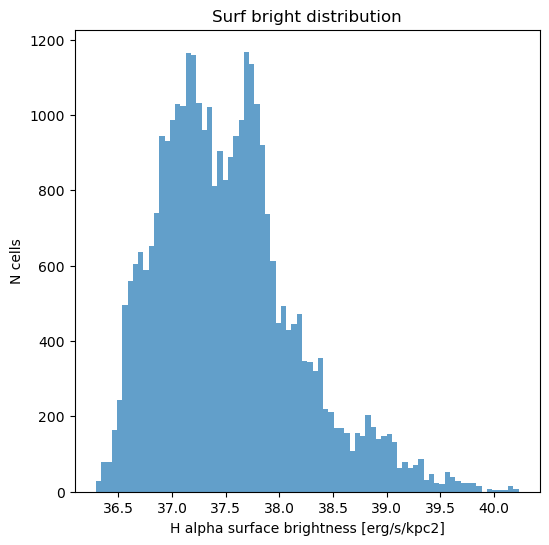

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
raw = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (((temperature['T'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128) / 1e4)**(-0.942-0.030*np.log((temperature['T'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128) / 1e4))) * (((electron_density['ne'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128))**2 * number_density_cf * 4. *1e6)
plot_data = np.sum(raw.transpose(2, 1, 0), axis=-1).transpose()
plt.hist(np.log10(plot_data.flatten()), bins=80, alpha=0.7)
plt.title('Surf bright distribution')
plt.ylabel('N cells')
plt.xlabel('H alpha surface brightness [erg/s/kpc2]')
plt.show()

8388608


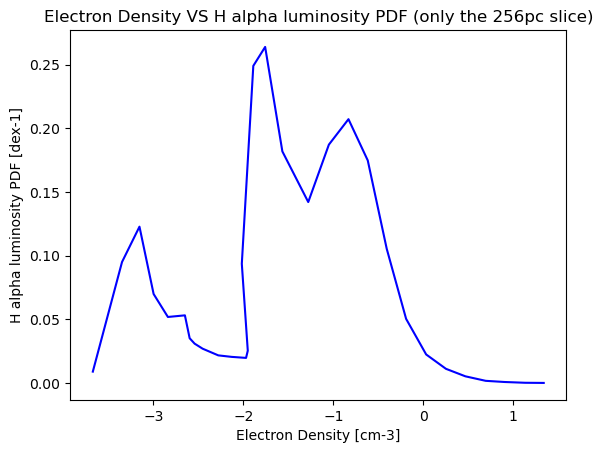

In [10]:
raw_lum = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (((temperature['T'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128) / 1e4)**(-0.942-0.030*np.log((temperature['T'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128) / 1e4))) * (((electron_density['ne'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128))**2 * number_density_cf * volume)
sample_indices = np.random.choice(len(raw_lum.flatten()), size=int(1 * len(raw_lum.flatten())), replace=False)
sample_lum = np.log10((raw_lum.flatten())[sample_indices])
sample_dens = np.log10((((electron_density['ne'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128)).flatten())[sample_indices])
print(len(sample_dens))

num_bins = 30
lum_bins = np.linspace(np.min(sample_lum), np.max(sample_lum), num_bins + 1)
bin_centers = (lum_bins[:-1] + lum_bins[1:]) / 2
densities_per_bin = []

for i in range(num_bins):
    in_bin = (sample_lum >= lum_bins[i]) & (sample_lum < lum_bins[i + 1])
    mean_density = np.mean(sample_dens[in_bin]) if np.any(in_bin) else 0
    densities_per_bin.append(mean_density)
hist, bin_edges = np.histogram(sample_lum, bins=lum_bins, density=True)


plt.rcParams['agg.path.chunksize'] = 1000
plt.plot(densities_per_bin, hist, color='b')
plt.title('Electron Density VS H alpha luminosity PDF (only the 256pc slice)')
plt.ylabel('H alpha luminosity PDF [dex-1]')
plt.xlabel('Electron Density [cm-3]')
#plt.axvline(x=-2.5, color='k', linestyle='--')
plt.show()

1006


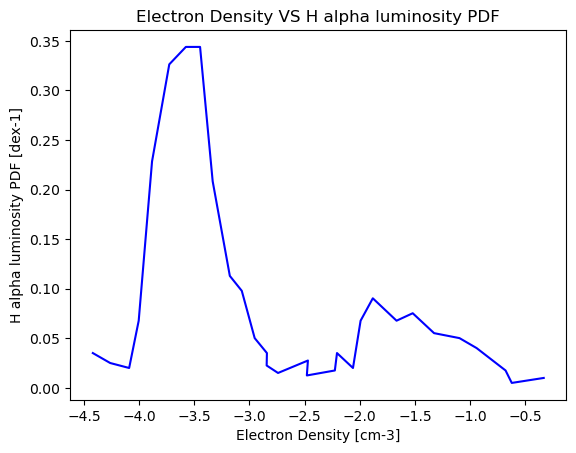

In [11]:
raw_lum = h_alpha_energy * (1.17e-13 / (4*np.pi)) * ((temperature['T'].data / 1e4)**(-0.942-0.030*np.log(temperature['T'].data / 1e4))) * ((electron_density['ne'].data)**2 * number_density_cf * volume)
sample_indices = np.random.choice(len(raw_lum.flatten()), size=int(0.00001 * len(raw_lum.flatten())), replace=False)
sample_lum = np.log10((raw_lum.flatten())[sample_indices])
sample_dens = np.log10((electron_density['ne'].data.flatten())[sample_indices])
print(len(sample_dens))

num_bins = 30
lum_bins = np.linspace(np.min(sample_lum), np.max(sample_lum), num_bins + 1)
bin_centers = (lum_bins[:-1] + lum_bins[1:]) / 2
densities_per_bin = []

for i in range(num_bins):
    in_bin = (sample_lum >= lum_bins[i]) & (sample_lum < lum_bins[i + 1])
    mean_density = np.mean(sample_dens[in_bin]) if np.any(in_bin) else 0
    densities_per_bin.append(mean_density)
hist, bin_edges = np.histogram(sample_lum, bins=lum_bins, density=True)


plt.rcParams['agg.path.chunksize'] = 1000
plt.plot(densities_per_bin, hist, color='b')
plt.title('Electron Density VS H alpha luminosity PDF')
plt.ylabel('H alpha luminosity PDF [dex-1]')
plt.xlabel('Electron Density [cm-3]')
#plt.axvline(x=-2.5, color='k', linestyle='--')
plt.show()

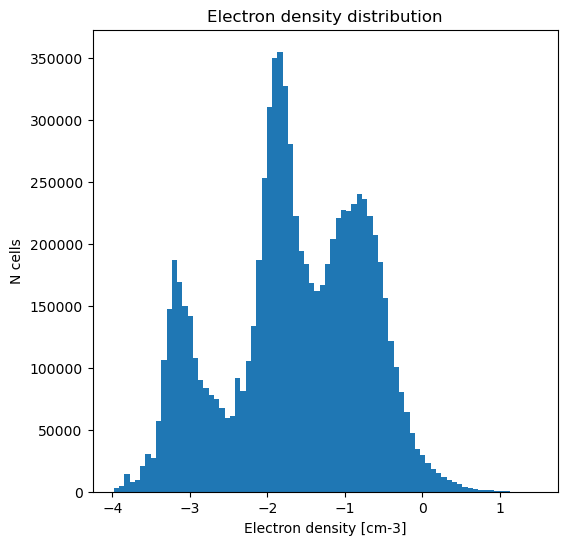

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.hist(np.log10((electron_density['ne'].data.transpose(2, 1, 0)[:,:,704:832]).flatten()), bins=80)
plt.title('Electron density distribution')
plt.ylabel('N cells')
plt.xlabel('Electron density [cm-3]')
plt.show()

In [13]:
electron_density['ne'].data.shape

(1536, 256, 256)

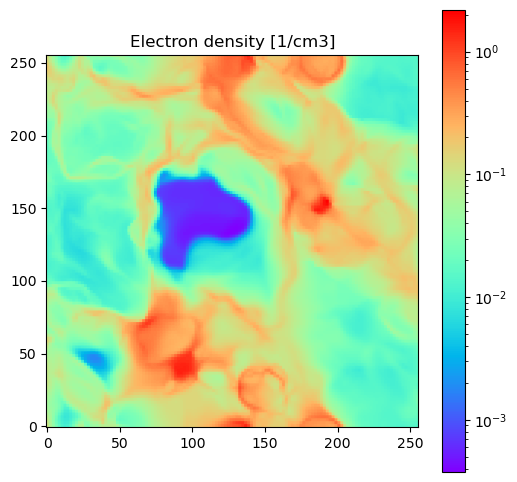

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
lol = (electron_density['ne'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128)
plot_data = np.mean(lol, axis=-1).transpose()
im = ax.imshow(plot_data, origin='lower', cmap='rainbow', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.title('Electron density [1/cm3]')
plt.colorbar(im, ax=ax)
plt.show()

In [56]:
# H alpha 3D data (Bruce Draine 2011), SED and Dust array
Halfa_array = []
SED_array = []
dust_array = []
ID_number = 0

for i in range(Nx[0]):
    print(i)
    for j in range(Nx[1]):
        for k in range(704, 832):
            xmin_val = xmin[i]
            ymin_val = ymin[j]
            zmin_val = zmin[k]
            xmax_val = xmax[i]
            ymax_val = ymax[j]
            zmax_val = zmax[k]

            T_4 = (temperature['T'].data)[k, j, i].astype(np.float64) / 1e4
            ne2 = (electron_density['ne'].data)[k, j, i].astype(np.float64)

            h_alpha_luminosity_val = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (T_4**(-0.942-0.030*np.log(T_4))) * (ne2**2 * number_density_cf * volume)

            dust_density_val = (gas_density['rho'].data)[k, j, i].astype(np.float64) * dust_to_gas_ratio
            temperature_val = (temperature['T'].data)[k, j, i].astype(np.float64)

            #vx_val = (velocities_x['vx'].data)[k, j, i]
            #vy_val = (velocities_y['vy'].data)[k, j, i]
            #vz_val = (velocities_z['vz'].data)[k, j, i]
 

            
            Halfa_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, ID_number, dust_density_val])
            SED_array.append([h_alpha_wave, h_alpha_luminosity_val])
            dust_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, dust_density_val, temperature_val])
            ID_number = ID_number + 1


Halfa_array = np.array(Halfa_array)
SED_array = np.array(SED_array)
dust_array = np.array(dust_array)

print("Final ID_Number: " + str(ID_number))
del ID_number

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
Final ID_Number: 8388608


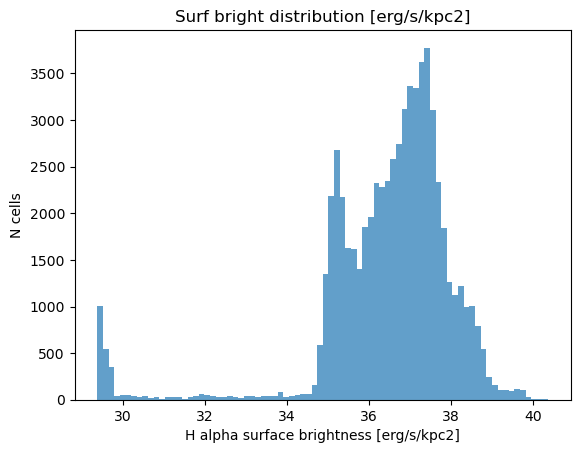

In [57]:
plot_data = np.sum(SED_array[:,1].reshape(256, 256, 128), axis=-1).transpose()
plot_data = plot_data / (4. * 4. * 1e-6)
plt.hist(np.log10(plot_data.flatten()), bins=80, alpha=0.7)
#plt.axvline(x=10**37, color='red', linestyle='--', label='x = 37')
#plt.axvline(x=10**41, color='blue', linestyle='--', label='x = 41')
plt.title('Surf bright distribution [erg/s/kpc2]')
plt.ylabel('N cells')
plt.xlabel('H alpha surface brightness [erg/s/kpc2]')
plt.show()

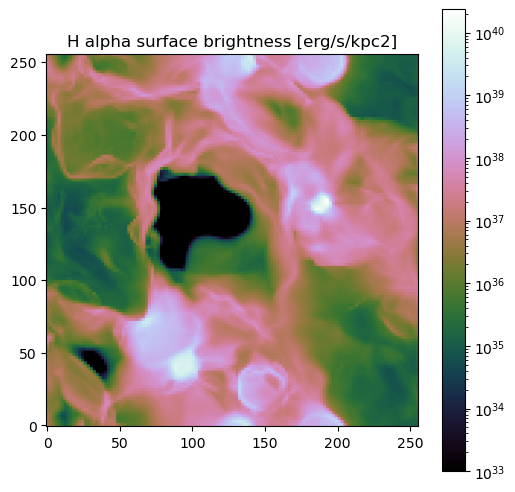

Dynamical range 29.37290230637849 to 40.37469499789299
Actual Dynamical range 37 to 41


In [58]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.sum(SED_array[:,1].reshape(256, 256, 128), axis=-1).transpose()
plot_data = plot_data / (4. * 4. * 1e-6)
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=1e33, vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('H alpha surface brightness [erg/s/kpc2]')
plt.show()
print('Dynamical range ' + str(np.log10(plot_data.min())) + ' to ' + str(np.log10(plot_data.max())) )
print('Actual Dynamical range ' + str(37) + ' to ' + str(41) )

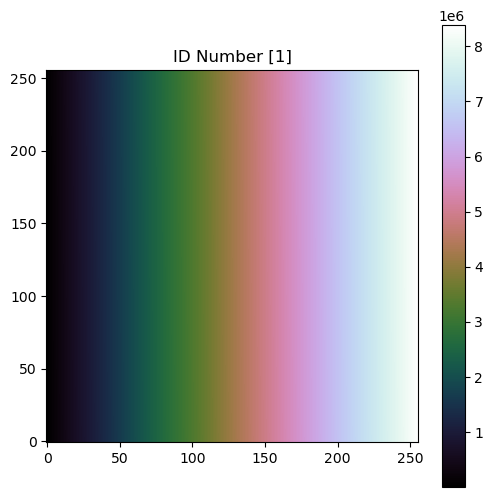

Dynamical range 0.0 to 8388607.0


In [55]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.mean(Halfa_array[:,6].reshape(256, 256, 128), axis=-1).transpose()
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower')
plt.colorbar(im, ax=ax)
ax.set_title('ID Number [1]')
plt.show()
print('Dynamical range ' + str(Halfa_array[:,6].min()) + ' to ' + str(Halfa_array[:,6].max()) )

In [107]:
header = """# Halfa_Ridotto.txt: import file for cell source -- Halfa
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: index (1)
# Column 8: mass density (g/cm3)
#
"""

with open(f"{output_dir}Halfa_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, Halfa_array, fmt="%g")

'''
header = """# SED_Ridotto.txt: import file for SED -- SED
# Column 1: wavelength (micron)
# Column 2: neutral monochromatic luminosity (erg/s)
#
"""

with open(f"{output_dir}SED_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, SED_array, fmt="%g")
'''

header = """# Dust_Ridotto.txt: import file for cell media -- dust
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass density (g/cm3)
# Column 8: temperature (K)
#
"""

with open(f"{output_dir}Dust_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, dust_array, fmt="%g")

In [15]:
from pts.storedtable.io import writeStoredTable
def convertMonochromaticSimulation(wavelengths, luminosities, outFilePath):
    erg_to_watt = 1e-7  # Conversion from erg/s a watt
    luminosities_per_micron = luminosities * erg_to_watt
    w = np.array([0.656, 0.657])
    print(w)

    ID = np.arange(len(luminosities))
    print(ID.shape)
    
    L = np.zeros((len(w), len(luminosities)))
    L[0, :] = luminosities * 1e3
    L[1, :] = luminosities * 1e3
    print(L.shape)
    print(L)

    writeStoredTable(outFilePath,['lambda', 'index'], ['m', '1'], ['lin', 'lin'],[w*1e-6, ID],['Llambda'], ['W/m'], ['lin'], [L*1e6])
    
convertMonochromaticSimulation(SED_array[:,0],SED_array[:,1],f"{output_dir}SEDfamily_Ridotto.stab")

[0.656 0.657]
(8388608,)
(2, 8388608)
[[6.89688020e+31 6.89688020e+31 6.07549038e+31 ... 1.62932931e+31
  1.57614671e+31 1.57614671e+31]
 [6.89688020e+31 6.89688020e+31 6.07549038e+31 ... 1.62932931e+31
  1.57614671e+31 1.57614671e+31]]


In [16]:
from pts.storedtable.io import readStoredTable
readStoredTable(f"{output_dir}SEDfamily_Ridotto.stab")

{'axisNames': ['lambda', 'index'],
 'axisUnits': ['m', '1'],
 'axisScales': ['lin', 'lin'],
 'quantityNames': ['Llambda'],
 'quantityUnits': ['W/m'],
 'quantityScales': ['lin'],
 'lambda': <Quantity [6.56e-07, 6.57e-07] m>,
 'index': <Quantity [0.000000e+00, 1.000000e+00, 2.000000e+00, ..., 8.388605e+06,
            8.388606e+06, 8.388607e+06]>,
 'Llambda': <Quantity [[6.89688020e+37, 6.89688020e+37, 6.07549038e+37, ...,
             1.62932931e+37, 1.57614671e+37, 1.57614671e+37],
            [6.89688020e+37, 6.89688020e+37, 6.07549038e+37, ...,
             1.62932931e+37, 1.57614671e+37, 1.57614671e+37]] W / m>}

In [47]:
def convertTextInStoredColumn( filepath : (str,"name or path of the column text file to be converted"),
        names : (str,"white-space-separated list of column names"),
        units : (str,"white-space-separated list of unit strings"),
        ) -> "convert column text file to SKIRT stored columns format":

    import numpy as np
    import pts.storedtable as stab
    import pts.utils as ut

    # get the file paths
    inpath = ut.absPath(filepath)
    outpath = inpath.with_suffix('.scol')

    # load the text file contents
    values = np.loadtxt(inpath, unpack=True)

    # construct list of names and unit string, allowing commas as separators

    # save the binary file
    stab.writeStoredColumns(outpath, names, units, values)

convertTextInStoredColumn(f"{output_dir}Halfa_Ridotto.txt", ['xmin', 'ymin', 'zmin', 'xmax', 'ymax', 'zmax', 'density', 'ID'], ['pc', 'pc', 'pc', 'pc', 'pc', 'pc', 'g/cm3', '1'], )

In [14]:
image_fits.mean()

inf

8.355997329728561e-28


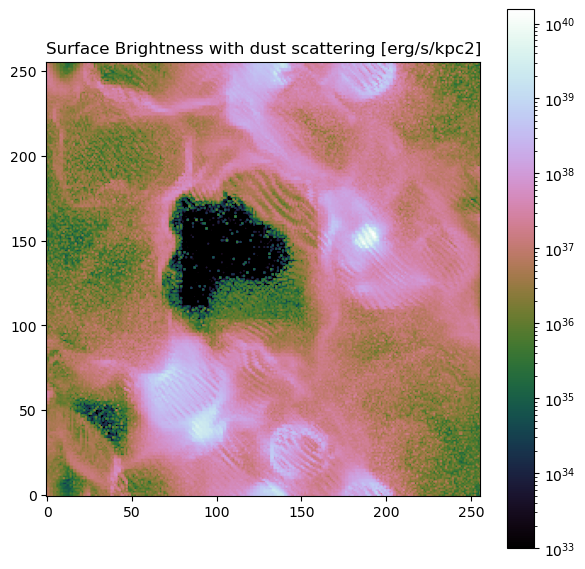

BUNIT: MJy/sr
Dynamic Range: 1.565071869998433e+29 to 1.5532779018278624e+40
Integrated flux: 3.4013458390073575e+42 Jy


In [20]:
from astropy.io import fits
prefattore = 1e23 * 1e8 * 1e-6 / (4*np.pi* (3.086e25)**2) # (erg/s) -> (MJy/sr)
print(prefattore)

with fits.open(f"{output_dir}HaTr2_i0_total.fits") as hdul:
    image_fits = hdul[0].data.astype(np.float64) / prefattore
    image_fits = image_fits / (16e-6)
    header = hdul[0].header
    
fig, ax = plt.subplots(figsize=(7, 7))
cmap = plt.get_cmap('cubehelix').copy()
cmap.set_under('black')
im = ax.imshow(np.squeeze(image_fits), cmap=cmap, origin='lower', norm=LogNorm(vmin=1e33, vmax=image_fits.max()))
plt.colorbar(im, ax=ax)
ax.set_title('Surface Brightness with dust scattering [erg/s/kpc2]')
plt.show()

print(f"BUNIT: {header['BUNIT']}")
print('Dynamic Range: ' + str(image_fits.min()) + ' to ' + str(image_fits.max()))
print('Integrated flux: ' + str(np.sum(image_fits)) + ' Jy')

In [18]:
# For the moment, we do not employ velocity
# Column 7: velocity vx (km/s)
# Column 8: velocity vy (km/s)
# Column 9: velocity vz (km/s)

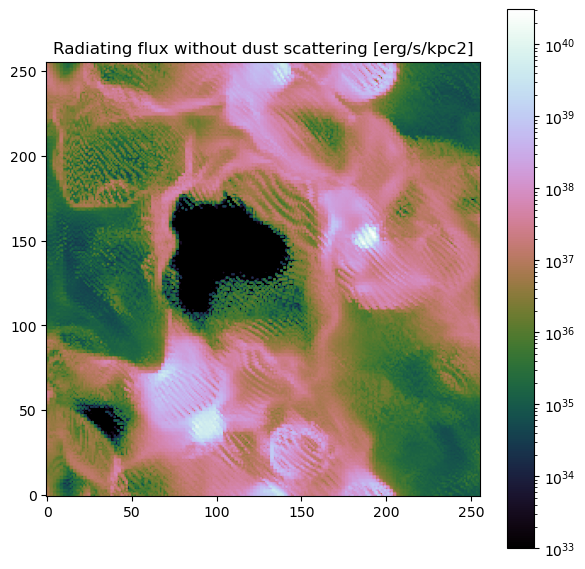

BUNIT: MJy/sr
Dynamic Range: 1.5301063371919361e+29 to 3.094183133354338e+40
Integrated flux: 4.724722359464879e+42 Jy


In [41]:
with fits.open(f"{output_dir}HaTr_i0_nodust_total.fits") as hdul:
    image_fits_nodust = hdul[0].data.astype(np.float64) / prefattore
    image_fits_nodust = image_fits_nodust / (16e-6)
    header_nodust = hdul[0].header

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(np.squeeze(image_fits_nodust), cmap='cubehelix', origin='lower', norm=LogNorm(vmin=1e33, vmax=image_fits_nodust.max()))
plt.colorbar(im, ax=ax)
ax.set_title('Radiating flux without dust scattering [erg/s/kpc2]')
#plt.xlim(150,200)
#plt.ylim(130,180)
#plt.grid()
plt.show()

print(f"BUNIT: {header_nodust['BUNIT']}")
print('Dynamic Range: ' + str(image_fits_nodust.min()) + ' to ' + str(image_fits_nodust.max()))
print('Integrated flux: ' + str(np.sum(image_fits_nodust)) + ' Jy')

The 99th percentile is 2624083.2721042796


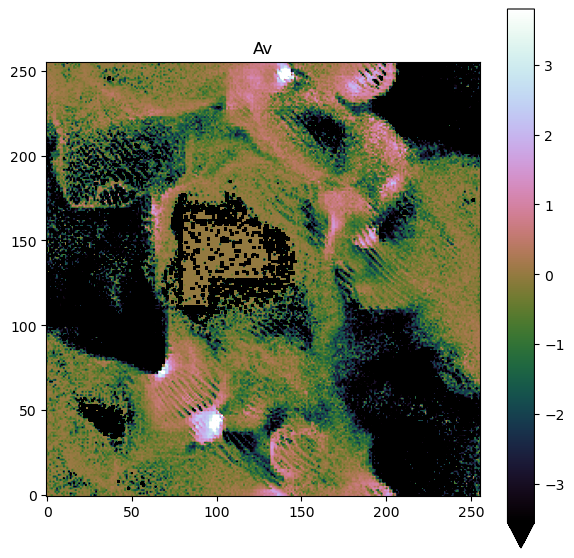

BUNIT: MJy/sr
Dynamic Range: -9.77899803561627 to 10.444526993110628


In [22]:
def percentile99(array):
    sorted_values = np.sort(array.flatten())
    cumulative = np.cumsum(sorted_values) / np.sum(sorted_values)
    return sorted_values[np.searchsorted(cumulative, 0.80)]

image_fits_atten_nomasked = np.squeeze(image_fits) / np.squeeze(np.where(image_fits_nodust == 0, 0.00005801245, image_fits_nodust))
image_fits_atten = np.ma.masked_where(image_fits_atten_nomasked >= 50, image_fits_atten_nomasked)
print('The 99th percentile is ' + str(percentile99(image_fits_atten_nomasked)))

image_fits_atten = - 2.5 * np.log(np.squeeze(image_fits_atten))

fig, ax = plt.subplots(figsize=(7, 7))
palette = plt.cm.cubehelix.with_extremes(bad='k')
im = ax.imshow(np.squeeze(image_fits_atten), cmap=palette, origin='lower', vmin=-3.555999, vmax=3.7980096)
plt.colorbar(im, ax=ax, extend='min')
ax.set_title('Av')
#plt.xlim(150,200)
#plt.ylim(130,180)
#plt.grid()
plt.show()

print(f"BUNIT: {header_nodust['BUNIT']}")
print('Dynamic Range: ' + str(image_fits_atten.min()) + ' to ' + str(image_fits_atten.max()))

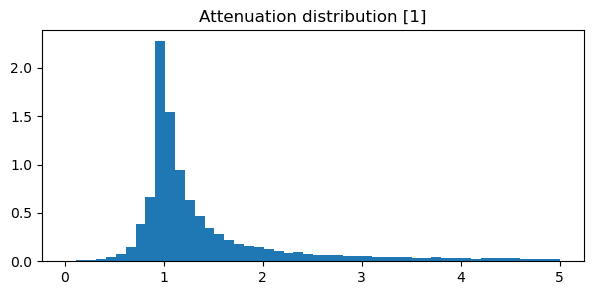

In [23]:
fig, ax = plt.subplots(figsize=(7, 3))
im = ax.hist(image_fits_atten_nomasked.flatten()[image_fits_atten_nomasked.flatten() < 5], bins=50, density=True)
ax.set_title('Attenuation distribution [1]')
plt.show()

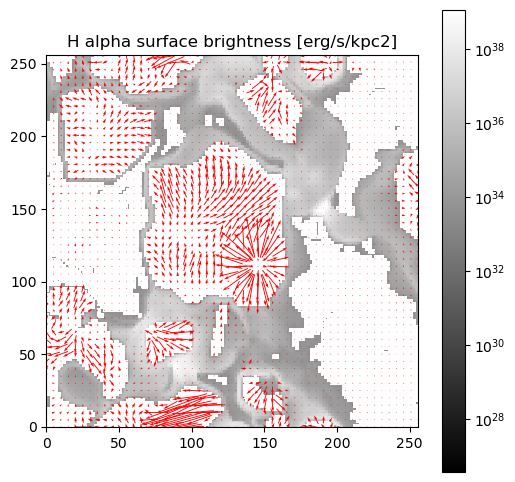

In [29]:
# 56 Halpha emission overplotted on velocity field (from 48 slice to 79)
s_n = 56

velocities_bubble = np.stack((Halfa_array[:,8].reshape(256, 256, 128)[...,s_n],Halfa_array[:,9].reshape(256, 256, 128)[...,s_n]))

fig, ax = plt.subplots(figsize=(6, 6))
plot_data = SED_array[:,1].reshape(256, 256, 128)[...,s_n].transpose()
plot_data = plot_data / (4. * 4. * 1e-6)

step=5
im = ax.imshow(np.ma.masked_where(plot_data <= 5e33, plot_data), cmap='grey', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.quiver(np.linspace(0, 256, 256)[::step], np.linspace(0, 256, 256)[::step], velocities_bubble[0][::step, ::step].transpose(), velocities_bubble[1][::step, ::step].transpose(), pivot='middle', color='red')

plt.xlim(0,256)
plt.ylim(0,256)
plt.colorbar(im, ax=ax)
ax.set_title('H alpha surface brightness [erg/s/kpc2]')
plt.show()

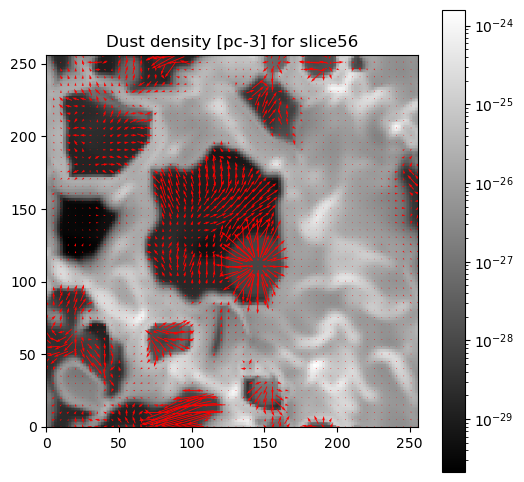

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = dust_array[:,6].reshape(256, 256, 128)[...,56].transpose()

step=5
im = ax.imshow(plot_data, cmap='grey', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.quiver(np.linspace(0, 256, 256)[::step], np.linspace(0, 256, 256)[::step], velocities_bubble[0][::step, ::step].transpose(), velocities_bubble[1][::step, ::step].transpose(), pivot='middle', color='red')

plt.xlim(0,256)
plt.ylim(0,256)
plt.colorbar(im, ax=ax)
ax.set_title('Dust density [pc-3] for slice ' + str(56))
plt.show()